# Modelling the glitch

With `asterion.GlitchModel`, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [1]:
import numpy as np
import pandas as pd

import asterion as ast
from asterion import GlitchModel, Inference

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Data

Import stellar evolutionary track.

In [2]:
track = pd.read_csv('data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


Choose a star from the evolutionary track.

In [3]:
profile = track.loc[708]

Extract modes from star.

In [4]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2357.69 muHz
delta_nu ~ 111.84 muHz


In [5]:
n_max = nu_max_sca / delta_nu_fit - 1.
n_max

20.08073195768814

In [6]:
n_max = int(nu_max_sca / delta_nu_fit - 1.)

n = np.arange(n_max - 7, n_max + 7)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

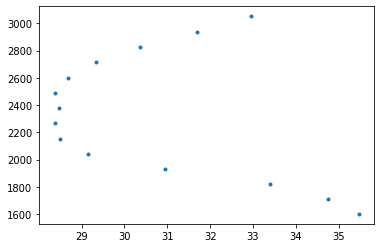

In [7]:
import matplotlib.pyplot as plt

ax = plt.gca()
ax.plot(nu%delta_nu_fit, nu, '.');

## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameter `epsilon`, but by default this is fairly uninformative. We can also pass the effective termperature of the star to improve our prior for the glitch acoustic depths.

In [8]:
delta_nu = (delta_nu_fit, 0.1)
nu_max = (nu_max_sca, 0.01*nu_max_sca)

In [9]:
model = GlitchModel(n, nu_max, delta_nu)
model

INFO[2022-02-17 12:17:21,514]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-02-17 12:17:21,514]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-02-17 12:17:21,515]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


GlitchModel(
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 (2357.692764609278, 23.57692764609278),
 (111.8411243661503, 0.1),
 teff=None,
 epsilon=None,
 num_pred=250,
 seed=0
)

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [10]:
infer = Inference(model, nu=nu, seed=25)

/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:106: UserWarning: Parameter 'phi_he' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC. Ignore this message if using nested sampling (default behaviour).
  warnings.warn(f"Parameter \'{value['name']}\' has " +
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:106: UserWarning: Parameter 'phi_cz' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC. Ignore this message if using nested sampling (default behaviour).
  warnings.warn(f"Parameter \'{value['name']}\' has " +


#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [11]:
infer.prior_predictive()

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

In [12]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

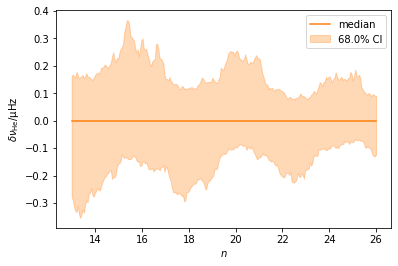

In [13]:
ast.plot_glitch(data, group='prior');

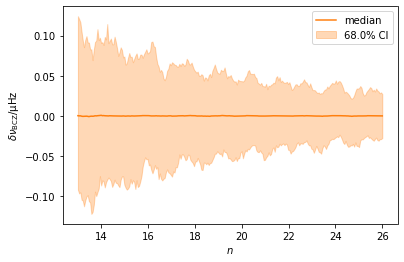

In [14]:
ast.plot_glitch(data, group='prior', kind='CZ');

#### Sample posterior

We can sample from the posterior using one of two methods, `'nested'` or `'mcmc'`. Nested sampling is better suited to multi-modal solutions over MCMC. Since we are fitting sinusoidal functions, there may be cases where one or more periods fit the data, leading to instability during MCMC. Also, the glitch phase term $\phi$ is circular, which can make it difficult to deal with the gradient at $\pm\pi$ for gradient-based MCMC sampling methods. Therefore, we recommend using the nested sampling method, although note that the package on which is is based, '`jaxns`' is still in early development.

If you want to sample using MCMC, follow the advice of the warning when initialising `Inference` and modify the distributions for $\phi$ like so,

```python
import numpyro.distributions as dist
model.he_glitch.phi = dist.VonMises(0.0, 0.1)
model.cz_glitch.phi = dist.VonMises(0.0, 0.1)
```

In [15]:
infer.sample(
    num_samples=2000,
    method='nested',  # default method 
    num_live_points=150,  # Should be ~ 50 per expected posterior mode
    depth=5,
)

Running nested sampling using the 'multi_ellipsoid' sampler with 150 live points and 100000 maximum samples...
Completed in 12.2 seconds.


#### Posterior predictive check

In [16]:
infer.posterior_predictive()

When use nested sampling the inference data may produce some warnings. This is because we save the weighted samples in a custom group which is not defined by `arviz`. You may ignore these.

In [17]:
data = infer.get_data()
data

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

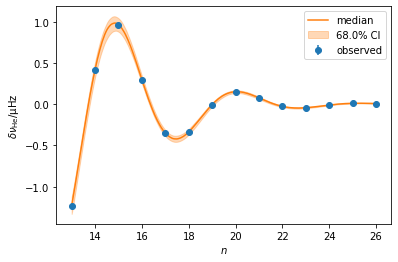

In [18]:
ast.plot_glitch(data);

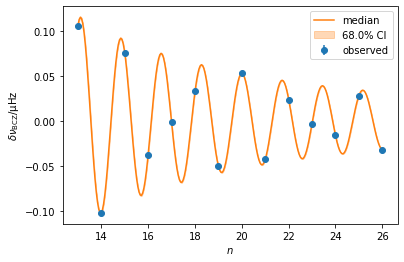

In [19]:
ast.plot_glitch(data, kind='CZ');

To quickly view the parameter names you can inspect `data` or just call the following.

In [20]:
ast.get_var_names(data)

['_nu_max',
 'a_cz',
 'a_he',
 'b_he',
 'delta_nu',
 'dnu_cz',
 'dnu_he',
 'epsilon',
 'he_amplitude',
 'he_nu_max',
 'log_a_cz',
 'log_a_he',
 'log_b_he',
 'log_tau_cz',
 'log_tau_he',
 'nu_bkg',
 'phi_cz',
 'phi_he',
 'tau_cz',
 'tau_he']

Let's just plot glitch parameter names.

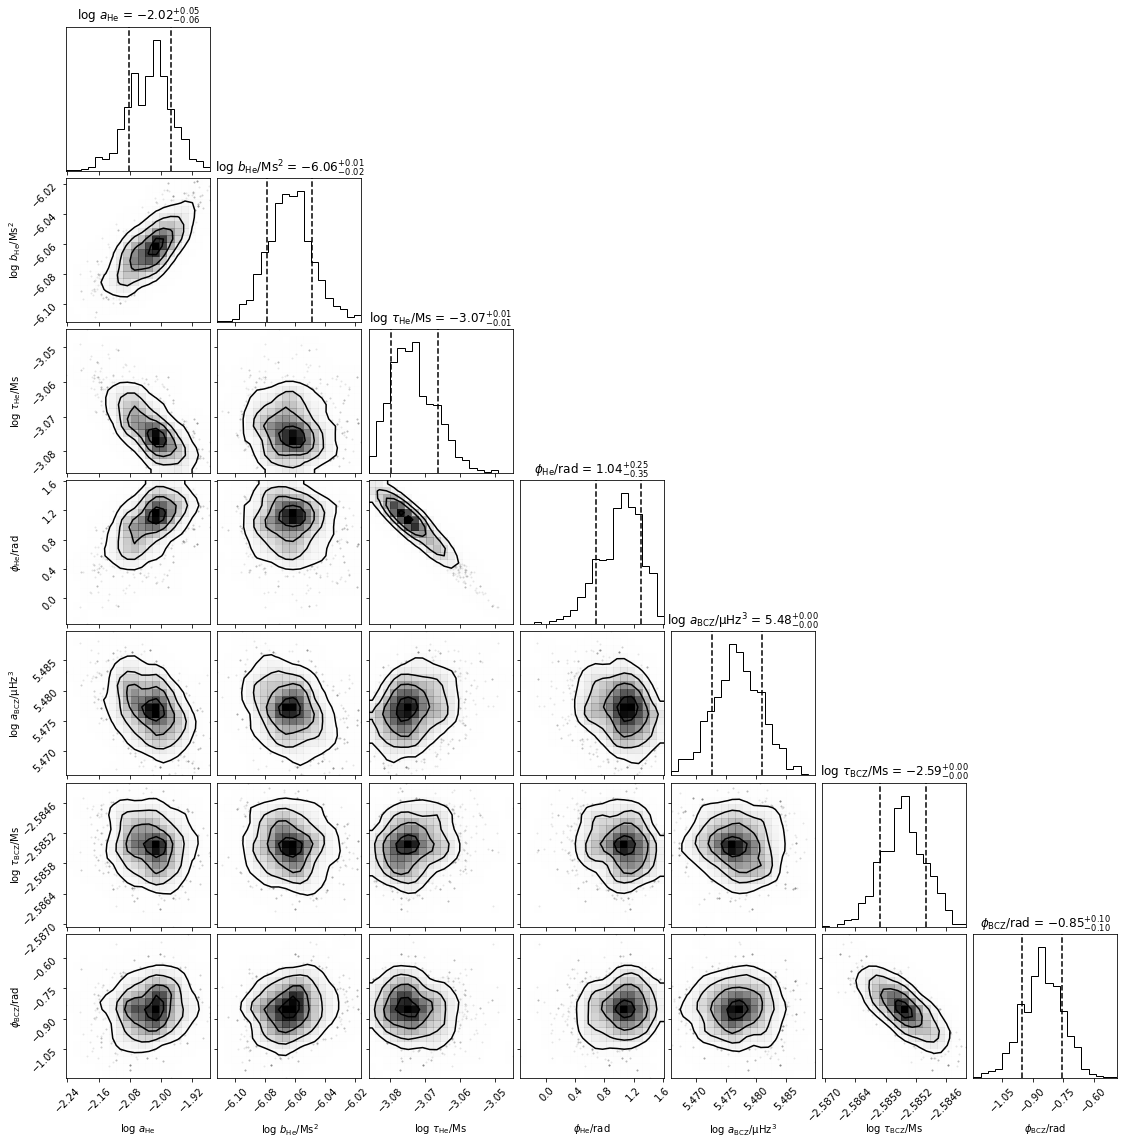

In [21]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names);

How about the background parameters and amplitudes at nu_max.

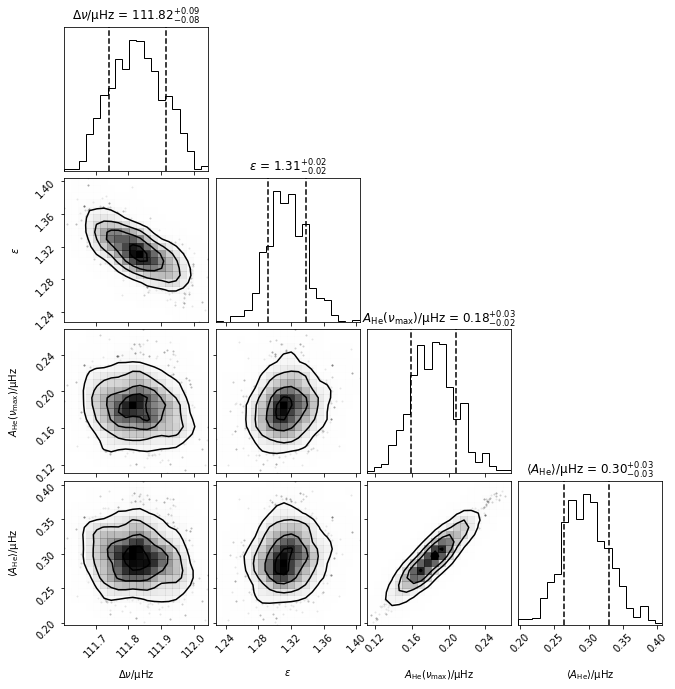

In [22]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_nu_max', 'he_amplitude']);

We can even plot from the posterior precictive, that is to say the predicted values for a given variable. E.g. `'nu'` for the first 5 radial orders.

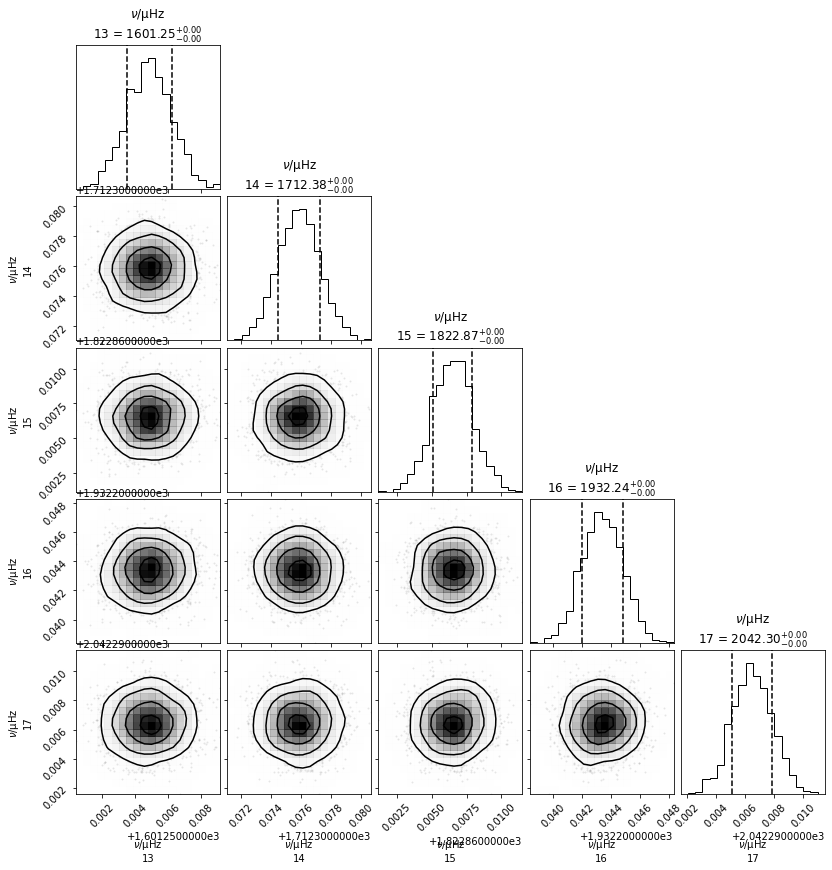

In [23]:
ast.plot_corner(data, group='posterior_predictive', var_names=['nu'], coords={'n': n[:5]});

You can also pass data to `arviz` functions. Note, if using nested sampling, some functions like `traceplot` or `rhat` are useless since they are tailored to MCMC methods. 

Below, we plot the prior predictive and the posterior for the glitch parameters. We can use `asterion.get_labeller` to get an arviz labeller to replace variable names with their symbols and units.

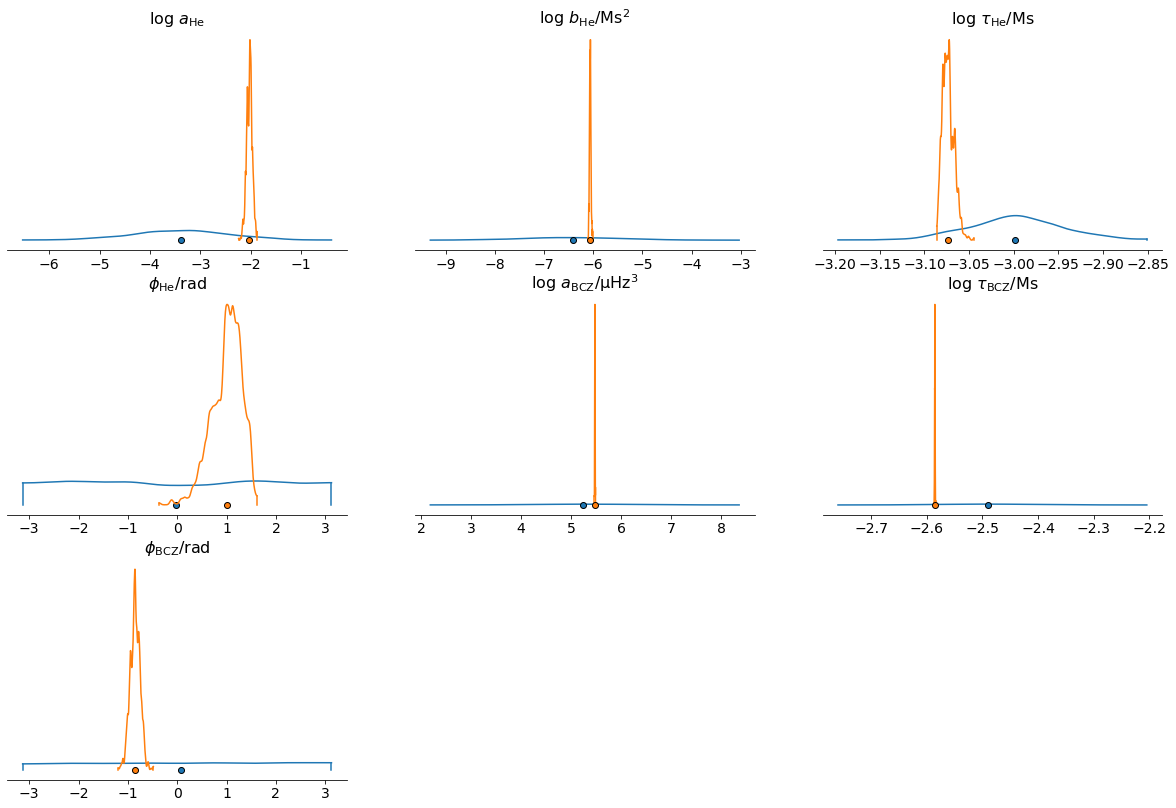

In [24]:
import arviz as az

labeller = ast.get_labeller(data, var_names=glitch_names)

ax = az.plot_density(data, group='prior_predictive', colors='C0', 
                     var_names=glitch_names, hdi_prob=1., labeller=labeller)
ax = az.plot_density(data, group='posterior', colors='C1', 
                     var_names=glitch_names, hdi_prob=1., labeller=labeller,
                     ax=ax)

#### Saving the inference data

In [25]:
data.to_netcdf('data/inference_data.nc')

'data/inference_data.nc'

#### Generating summary tables

You can generate a table for the results data for a chosen data dimension(s). E.g. all the data without any dimensions can be obtained like so. By default, the values are rounded using the standard error on the mean as a guide, although you may pass your own dictionary of formatting rules.

In [26]:
ast.get_table(data, dims=())

,_nu_max,a_cz,a_he,b_he,delta_nu,epsilon,he_amplitude,he_nu_max,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,phi_cz,phi_he,tau_cz,tau_he
metric,,,,,,,,,,,,,,,,,
mean,2355.6,299844.0,0.00944,8.648000e-07,111.826,1.3145,0.2959,0.1834,5.47688,-2.029,-6.0633,-2.585454,-3.0733,-0.853,1.004,0.002597,0.000845
sd,22.6,2772.0,0.00120,2.990000e-08,0.080,0.0238,0.0342,0.0253,0.00401,0.056,0.0150,0.000437,0.0065,0.100,0.302,0.000003,0.000013
16th,2332.7,296954.0,0.00828,8.345000e-07,111.741,1.2911,0.2640,0.1590,5.47269,-2.082,-6.0786,-2.585908,-3.0797,-0.951,0.690,0.002595,0.000832
50th,2355.8,299799.0,0.00948,8.640000e-07,111.825,1.3140,0.2955,0.1827,5.47683,-2.023,-6.0635,-2.585458,-3.0740,-0.853,1.043,0.002597,0.000843
84th,2377.5,302657.0,0.01061,8.930000e-07,111.914,1.3381,0.3301,0.2084,5.48095,-1.974,-6.0491,-2.584999,-3.0664,-0.757,1.297,0.002600,0.000858


You can also format the table using astropy, which makes use of quantity unit metadata.

In [52]:
table = ast.get_table(data, dims=(), fmt='astropy')
table

metric,_nu_max,a_cz,a_he,b_he,delta_nu,epsilon,he_amplitude,he_nu_max,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,phi_cz,phi_he,tau_cz,tau_he
,,uHz3,,Ms2,uHz,,uHz,uHz,dex(uHz3),dex,dex(Ms2),dex(Ms),dex(Ms),rad,rad,Ms,Ms
str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
mean,2357.5,232600.0,0.00067,2.62e-07,111.82,1.2995,0.283,0.279,5.334,-3.305,-6.668,-2.604,-3.0379,0.64,-0.34,0.002505,0.0009173
sd,20.2,93500.0,0.00059,1.37e-07,0.078,0.0215,0.055,0.055,0.187,0.332,0.319,0.048,0.0193,1.61,1.1,0.00029,4.11e-05
16th,2338.4,161500.0,0.00022,1.13e-07,111.744,1.278,0.228,0.226,5.208,-3.659,-6.949,-2.644,-3.0583,-1.28,-1.49,0.002269,0.0008744
50th,2357.3,225500.0,0.00049,2.55e-07,111.819,1.3001,0.282,0.275,5.353,-3.31,-6.593,-2.6,-3.0382,0.92,-0.28,0.002512,0.0009158
84th,2377.0,298500.0,0.00108,3.98e-07,111.896,1.3209,0.337,0.334,5.475,-2.966,-6.4,-2.563,-3.0184,2.36,0.85,0.002736,0.0009584


Or, we may want a table for all variables with the dimension $n$ (i.e. the individual modes) and from the posterior predictive group (to include the predicted frequencies for $n$).

In [28]:
ast.get_table(data, dims=('n',), group='posterior_predictive')

dnu_cz   dnu_he          nu   nu_bkg
metric n                                         
mean   13  0.105848 -1.23001  1601.25484  1600.73
       14 -0.101989  0.41771  1712.37583  1712.56
       15  0.075513  0.96048  1822.86650  1824.38
       16 -0.037332  0.29836  1932.24340  1936.21
       17 -0.001630 -0.34883  2042.29649  2048.03
...             ...      ...         ...      ...
84th   22  0.024545 -0.01808  2601.02280  2608.92
       23 -0.002220 -0.03662  2713.51296  2720.79
       24 -0.015408 -0.00476  2826.40069  2832.62
       25  0.028567  0.01393  2939.55963  2944.50
       26 -0.031638  0.00985  3052.67196  3056.32

[70 rows x 4 columns]

## Model with observational error

Synthesise observational error.

### Adding noise

In [29]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [30]:
rng = np.random.default_rng(42)

In [31]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [32]:
nu_obs = add_noise(rng, nu, nu_err)

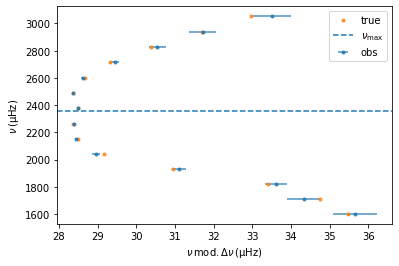

In [33]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_mod_obs, nu_obs, xerr=nu_err, fmt='.', label='obs', alpha=0.8)
ax.plot(nu_mod, nu, '.', label='true', alpha=0.8)

ax.axhline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

### Inference

We can add the uncertainty like so.

In [34]:
infer.nu_err = nu_err

In [35]:
infer.sample(
    num_samples=2000,
    method='nested',  # default method    
    num_live_points=150,  # Should be ~ 50 per expected posterior mode
    depth=5,
)

Running nested sampling using the 'multi_ellipsoid' sampler with 150 live points and 100000 maximum samples...
Completed in 11.0 seconds.


In [36]:
infer.posterior_predictive()

In [37]:
data = infer.get_data()
data

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

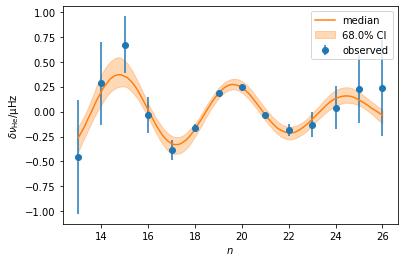

In [38]:
ast.plot_glitch(data, quantiles=[.16, .84]);

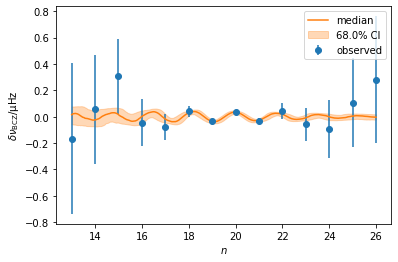

In [39]:
ast.plot_glitch(data, kind='CZ');

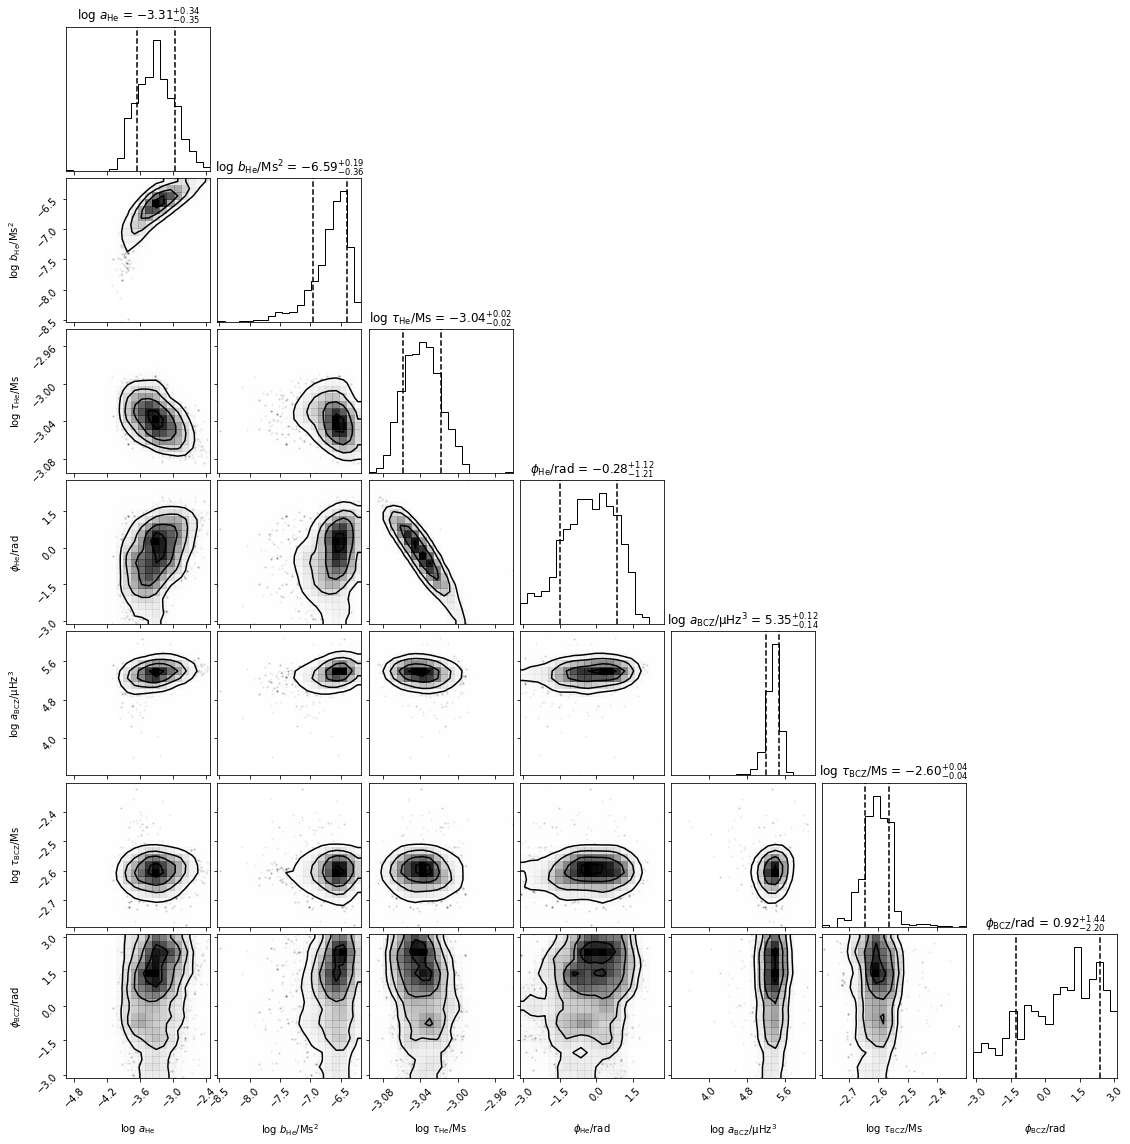

In [40]:
ast.plot_corner(data, var_names=glitch_names);

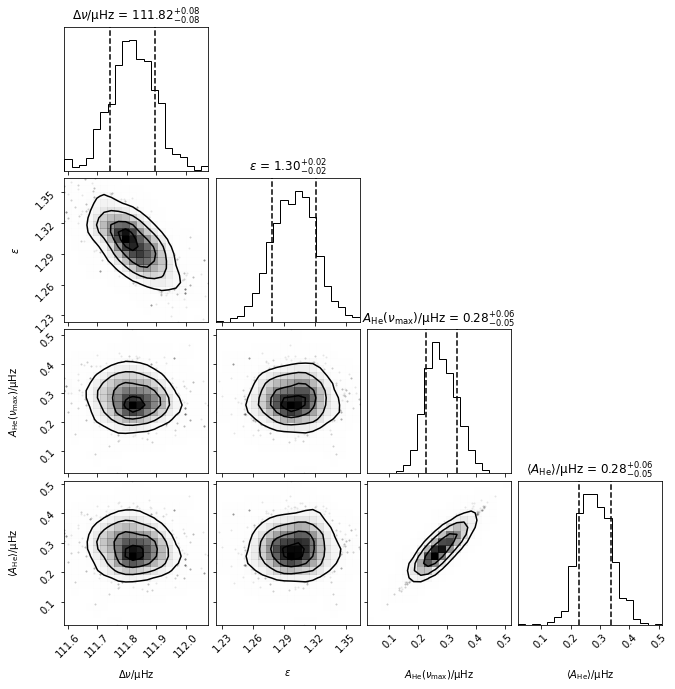

In [41]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_nu_max', 'he_amplitude']);

In [42]:
ast.get_table(data, dims=())

,_nu_max,a_cz,a_he,b_he,delta_nu,epsilon,he_amplitude,he_nu_max,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,phi_cz,phi_he,tau_cz,tau_he
metric,,,,,,,,,,,,,,,,,
mean,2357.5,232600.0,0.00067,2.620000e-07,111.820,1.2995,0.283,0.279,5.334,-3.305,-6.668,-2.604,-3.0379,0.64,-0.34,0.002505,0.000917
sd,20.2,93500.0,0.00059,1.370000e-07,0.078,0.0215,0.055,0.055,0.187,0.332,0.319,0.048,0.0193,1.61,1.10,0.000290,0.000041
16th,2338.4,161500.0,0.00022,1.130000e-07,111.744,1.2780,0.228,0.226,5.208,-3.659,-6.949,-2.644,-3.0583,-1.28,-1.49,0.002269,0.000874
50th,2357.3,225500.0,0.00049,2.550000e-07,111.819,1.3001,0.282,0.275,5.353,-3.310,-6.593,-2.600,-3.0382,0.92,-0.28,0.002512,0.000916
84th,2377.0,298500.0,0.00108,3.980000e-07,111.896,1.3209,0.337,0.334,5.475,-2.966,-6.400,-2.563,-3.0184,2.36,0.85,0.002736,0.000958


In [43]:
data.to_netcdf('data/obs_inference_data.nc')

'data/obs_inference_data.nc'